7/5/2019

I'll use the S0 model to score an utterance given the same target color across all three conditions and see how well this predicts the condition the utterance was created in.

The first step is to create the color contexts. This means for each target, generate the two conditions that it doesn't appear in. I want to first check and see if these already exist somewhere.

In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [99]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
import caption_featurizers                              # for getting caption representations
import color_featurizers                                # for getting color representations
from experiment import FeatureHandler                   # for combining caption and color features

from models import PytorchModel, ConditionPredictor, ColorEncoder, LiteralSpeakerScorer, CaptionGenerator  # model base that handles training / evaluation

In [219]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import copy
import pandas as pd
from functools import partial

In [334]:
%matplotlib inline
plt.style.use("ggplot")

In [89]:
import importlib
importlib.reload(caption_featurizers)
import caption_featurizers 

In [4]:
# get data
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [9]:
train_data[0].colors[0].hsl

[226, 81, 50]

In [12]:
all_train_target_hsl = [train_data[i].colors[0].hsl for i in range(len(train_data))]

In [13]:
all_train_target_hsl[:10]

[[226, 81, 50],
 [249, 25, 50],
 [301, 57, 50],
 [87, 66, 50],
 [156, 84, 50],
 [40, 7, 50],
 [82, 9, 50],
 [108, 16, 50],
 [5, 45, 50],
 [215, 13, 50]]

In [22]:
all_train_target_hsl_str = [str(hsl) for hsl in all_train_target_hsl]

In [23]:
train_hsl_counts = Counter(all_train_target_hsl_str)

In [27]:
train_hsl_counts.most_common()

[('[276, 48, 50]', 5),
 ('[322, 74, 50]', 4),
 ('[254, 13, 50]', 4),
 ('[70, 43, 50]', 4),
 ('[114, 29, 50]', 4),
 ('[244, 29, 50]', 4),
 ('[282, 43, 50]', 4),
 ('[162, 9, 50]', 4),
 ('[245, 40, 50]', 4),
 ('[32, 9, 50]', 4),
 ('[234, 74, 50]', 4),
 ('[280, 89, 50]', 4),
 ('[112, 29, 50]', 4),
 ('[65, 6, 50]', 4),
 ('[20, 47, 50]', 4),
 ('[272, 4, 50]', 4),
 ('[39, 24, 50]', 4),
 ('[303, 69, 50]', 4),
 ('[278, 43, 50]', 4),
 ('[311, 49, 50]', 4),
 ('[142, 39, 50]', 4),
 ('[336, 32, 50]', 4),
 ('[318, 3, 50]', 4),
 ('[58, 37, 50]', 4),
 ('[224, 66, 50]', 4),
 ('[119, 79, 50]', 4),
 ('[211, 88, 50]', 4),
 ('[62, 94, 50]', 4),
 ('[163, 34, 50]', 4),
 ('[229, 65, 50]', 4),
 ('[285, 78, 50]', 4),
 ('[156, 45, 50]', 4),
 ('[212, 19, 50]', 4),
 ('[254, 44, 50]', 4),
 ('[355, 14, 50]', 4),
 ('[115, 30, 50]', 4),
 ('[84, 31, 50]', 4),
 ('[320, 68, 50]', 4),
 ('[257, 19, 50]', 4),
 ('[94, 67, 50]', 4),
 ('[51, 88, 50]', 4),
 ('[116, 40, 50]', 4),
 ('[255, 22, 50]', 4),
 ('[124, 28, 50]', 4),
 ('

In [47]:
potential_hsls = [hsl for hsl, count in train_hsl_counts.most_common() if count >=3]

In [48]:
len(potential_hsls)

402

In [51]:
all_conditions_set = set(['close', 'split', 'far'])

all_conditions_hsl = []

for phsl in potential_hsls:
    # get indices from full list
    train_data_idxs = [i for i, hsl in enumerate(all_train_target_hsl_str) if hsl == phsl]
    phsl_conditions = [train_data[i].condition for i in train_data_idxs]
    if set(phsl_conditions) == all_conditions_set:
        all_conditions_hsl.append({phsl_conditions[i]: train_data_idxs[i] for i in range(len(train_data_idxs))})

In [53]:
len(all_conditions_hsl)

89

In [55]:
all_conditions_hsl[:10]

[{'close': 12209, 'far': 15406, 'split': 11903},
 {'close': 9495, 'far': 1121, 'split': 3035},
 {'close': 14815, 'far': 10777, 'split': 14835},
 {'close': 6855, 'far': 4536, 'split': 11327},
 {'close': 10660, 'far': 1655, 'split': 13996},
 {'close': 8806, 'far': 5863, 'split': 12091},
 {'close': 3666, 'far': 10573, 'split': 5688},
 {'close': 11206, 'far': 14859, 'split': 3947},
 {'close': 9166, 'far': 14022, 'split': 11811},
 {'close': 5045, 'far': 11773, 'split': 13377}]

Ok, so there are only 89 colors in the training data that are associated with contexts across all three conditions...
this means that I would have a total of 89*3=267 samples. This isn't really fair to compare to the 15,000 from the other data, so I'm going to have to generate distractors. That said, it does provide a good set to test things on, so I'll use it to develop the prediction framework now

In [220]:
# this is going to be pretty standard I think - let's start with character features

# define feature functions
caption_phi_character = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.CharacterTokenizer)

# we use a color featurizer because the code was designed to always use both color and text features. These 
# features will just be ignored in the model code
color_phi = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True)

# speaker's target is to predict tokens following the SOS token
def speaker_target(data_entry, caption_phi):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target

speaker_target_character = partial(speaker_target, caption_phi=caption_phi_character)

Scratch that - actually this isn't going to be standard because the input is a list of 3 color contexts. I'm not sure the feature handler can handle that. 

Ok, so upon further investigation, it looks like if we messed around with the data object, it could, but that would be very bad style. Instead I think what we should do is run the s0 speaker on all of the caption, context pairs and then do the normalization separately. I think that's probably the best way forward.

That means the first step is to create a data_entry list using just the entries we have, substituting in the captions

In [95]:
# here our target function is the speaker target so that we can easily extract the probability of the sentence
# train data is our train_data, so the character to index map matches what the speaker model was trained on
feature_handler_character = FeatureHandler(train_data, small_train_all_conditions_data,
                                 caption_phi_character, color_phi, target_fn=speaker_target_character, 
                                 randomized_colors=False)



In [96]:
X_train = feature_handler_character.train_features()
y_train = feature_handler_character.train_targets()

In [97]:
X_assess = feature_handler_character.test_features()
y_assess = feature_handler_character.test_targets()

In [102]:
# set up model
s0_character = LiteralSpeakerScorer(CaptionGenerator)
s0_character.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=feature_handler_character.caption_featurizer.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)
s0_character.load_model("../model/character_literal_speaker_full_context.params")

In [104]:
def output_to_score_lss(outputs, targets):
    all_scores = []
    for i, predictions in enumerate(outputs):
        scores = [0, 0, 0]
        for j, prediction in enumerate(predictions):
            scores[j] = np.sum(prediction[np.arange(len(targets[i])), targets[i]].numpy())
        all_scores.append(scores)
    return np.argmax(all_scores, axis=1) == 0

In [125]:
def output_to_likelihood(outputs, targets, target_idx=0):
    all_likelihoods = []
    for i, predictions in enumerate(outputs):
        log_prob = np.sum(predictions[target_idx][np.arange(len(targets[i])), targets[i]].numpy())
        all_likelihoods.append(log_prob)
        
#         for i in range(len(predictions)) # end token already removed
#             log_prob += predictions[targets[i]]

#         all_likelihoods.append(log_prob)
            
    return np.array(all_likelihoods)

In [ ]:
def likelihood_to_predictions(likelihoods, rounds_per_condition=3):
    # likelihoods is a 1d list, but every rounds_per_condition items represents a different set of conditions to 
    # softmax over. We don't care about the probabilities right now, however, so we just report the argmax of the
    # likelihoods from each rounds_per_condition rounds
    likelihoods = likelihoods.reshape(-1, rounds_per_condition)
    predictions = np.argmax(likelihoods, axis=1)
    
    # return predictions in index form
    return predictions

In [185]:
import pandas as pd

In [196]:
small_train_all_conditions_data = []
small_train_all_conditions_data_df = pd.DataFrame(index=list(range(len(small_train_all_conditions_data))), columns=train_data.data.columns)

entry_counter = 0
for triple in all_conditions_hsl:
    for condition, i in triple.items():
        # update caption in each condition's data entry to be the caption in each condition (this makes no sense)
        caption = train_data[i].caption
        
        # the first entry of the three will be the correct condition. The correct condition will always be at index 0
        new_data_entry = copy.deepcopy(train_data[i])
        small_train_all_conditions_data.append(new_data_entry)
        
        small_train_all_conditions_data_df.loc[entry_counter] = train_data.data.loc[i]
        small_train_all_conditions_data_df.loc[entry_counter, "contents"] = caption
        small_train_all_conditions_data_df.loc[entry_counter, "condition_group"] = condition
        entry_counter += 1
        
        
        for j in triple.values():
            if j == i: continue

            new_data_entry = copy.deepcopy(train_data[j])
            new_data_entry.caption = caption
            
            # data identical except for caption
            small_train_all_conditions_data.append(new_data_entry)
            small_train_all_conditions_data_df.loc[entry_counter] = train_data.data.loc[j]
            small_train_all_conditions_data_df.loc[entry_counter, "contents"] = caption
            small_train_all_conditions_data_df.loc[entry_counter, "condition_group"] = condition
            entry_counter += 1

        

In [197]:
small_train_all_conditions_data_df

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source,condition_group
0,9202-f,1.476490e+12,40,far,target,276,48,50,2,2,...,speaker,dark purple,853.0,1.0,2,10,10.0,2.0,human,far
1,8514-f,1.476481e+12,3,split,target,276,48,50,3,1,...,speaker,dark purple,258.0,1.0,1,4,4.0,1.0,human,far
2,6035-4,1.476482e+12,12,close,distr2,324,60,50,3,1,...,speaker,dark purple,777.0,0.0,2,14,14.0,2.0,human,far
3,8514-f,1.476481e+12,3,split,target,276,48,50,3,1,...,speaker,purp,258.0,1.0,1,4,4.0,1.0,human,split
4,9202-f,1.476490e+12,40,far,target,276,48,50,2,2,...,speaker,purp,853.0,1.0,2,10,10.0,2.0,human,split
5,6035-4,1.476482e+12,12,close,distr2,324,60,50,3,1,...,speaker,purp,777.0,0.0,2,14,14.0,2.0,human,split
6,6035-4,1.476482e+12,12,close,distr2,324,60,50,3,1,...,speaker,brighter purple,777.0,0.0,2,14,14.0,2.0,human,close
7,9202-f,1.476490e+12,40,far,target,276,48,50,2,2,...,speaker,brighter purple,853.0,1.0,2,10,10.0,2.0,human,close
8,8514-f,1.476481e+12,3,split,target,276,48,50,3,1,...,speaker,brighter purple,258.0,1.0,1,4,4.0,1.0,human,close
9,7584-c,1.459885e+12,28,far,target,244,29,50,3,3,...,speaker,purple,NaN,1.0,1,6,6.0,1.0,human,far


In [198]:
small_train_all_conditions_data_df.to_csv("../data/csv/train_corpus_condition_pred_small.csv", header=True, index=False)

In [199]:
import pickle as pkl
with open("../data/entries/train_entries_condition_pred_small.pkl", "wb") as pkl_file:
    pkl.dump(small_train_all_conditions_data, pkl_file)

In [200]:
# load in data
train_cp_data_small = MonroeData("../data/csv/train_corpus_condition_pred_small.csv", "../data/entries/train_entries_condition_pred_small.pkl")

In [201]:
feature_handler_character_test = FeatureHandler(train_data, train_cp_data_small,
                                 caption_phi_character, color_phi, target_fn=speaker_target_character, 
                                 randomized_colors=False)

In [202]:
X_assess = feature_handler_character_test.test_features()
y_assess = feature_handler_character_test.test_targets()

In [213]:
cp_outputs = s0_character.predict(X_assess)

cp_likelihood = output_to_likelihood(cp_outputs, y_assess)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data_small])
cp_preds_str = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

In [218]:
print(classification_report(cp_truth_str, cp_preds_str))

              precision    recall  f1-score   support

       close       0.50      0.43      0.46        89
         far       0.56      0.64      0.60        89
       split       0.48      0.48      0.48        89

   micro avg       0.52      0.52      0.52       267
   macro avg       0.51      0.52      0.51       267
weighted avg       0.51      0.52      0.51       267



In [222]:
# out of curiosity, let's try with a different tokenizer - endings tokenizer:
# set up feature handler
caption_phi_endings = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.EndingTokenizer)
speaker_target_endings = partial(speaker_target, caption_phi=caption_phi_endings)

feature_handler_endings_test = FeatureHandler(train_data, train_cp_data_small,
                                 caption_phi_endings, color_phi, target_fn=speaker_target_endings,
                                 randomized_colors=False)

# set up model
s0_endings = LiteralSpeakerScorer(CaptionGenerator)
s0_endings.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=feature_handler_endings_test.caption_featurizer.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)
s0_endings.load_model("../model/literal_speaker_30epochGLOVE.params")

In [223]:
X_assess_endings = feature_handler_endings_test.test_features()
y_assess_endings = feature_handler_endings_test.test_targets()

In [224]:
cp_outputs = s0_endings.predict(X_assess_endings)

cp_likelihood = output_to_likelihood(cp_outputs, y_assess_endings)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data_small])
cp_preds_str = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

In [225]:
print(classification_report(cp_truth_str, cp_preds_str))

              precision    recall  f1-score   support

       close       0.40      0.40      0.40        89
         far       0.53      0.58      0.56        89
       split       0.49      0.44      0.46        89

   micro avg       0.48      0.48      0.48       267
   macro avg       0.47      0.48      0.47       267
weighted avg       0.47      0.48      0.47       267



In [226]:
# out of curiosity, once more let's try with a different tokenizer - subword tokenizer:
# set up feature handler
caption_phi_subword = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.SentencePieceTokenizer)
speaker_target_subword = partial(speaker_target, caption_phi=caption_phi_subword)

feature_handler_subword_test = FeatureHandler(train_data, train_cp_data_small,
                                 caption_phi_subword, color_phi, target_fn=speaker_target_subword,
                                 randomized_colors=False)

# set up model
s0_subword = LiteralSpeakerScorer(CaptionGenerator)
s0_subword.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=feature_handler_subword_test.caption_featurizer.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)
s0_subword.load_model("../model/subword100_literal_speaker_full_context.params")

In [227]:
X_assess_subword = feature_handler_subword_test.test_features()
y_assess_subword = feature_handler_subword_test.test_targets()

In [228]:
cp_outputs = s0_subword.predict(X_assess_subword)

cp_likelihood = output_to_likelihood(cp_outputs, y_assess_subword)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data_small])
cp_preds_str = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

In [229]:
print(classification_report(cp_truth_str, cp_preds_str))

              precision    recall  f1-score   support

       close       0.53      0.57      0.55        89
         far       0.56      0.56      0.56        89
       split       0.50      0.46      0.48        89

   micro avg       0.53      0.53      0.53       267
   macro avg       0.53      0.53      0.53       267
weighted avg       0.53      0.53      0.53       267



In [362]:
# now let's try with the entire training set:
train_cp_data = MonroeData("../data/csv/train_corpus_condition_prediction.csv", "../data/entries/train_entries_condition_prediction.pkl")
#train_cp_data2 = train_cp_data

In [363]:
feature_handler_character_cp = FeatureHandler(train_data, train_cp_data,
                                 caption_phi_character, color_phi, target_fn=speaker_target_character, 
                                 randomized_colors=False)

In [364]:
X_assess_character_cp = feature_handler_character_cp.test_features()
y_assess_character_cp = feature_handler_character_cp.test_targets()

In [365]:
%%time
cp_outputs_character = s0_character.predict(X_assess_character_cp)

cp_likelihood = output_to_likelihood(cp_outputs_character, y_assess_character_cp)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data])
cp_preds_str_character = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

CPU times: user 4min 11s, sys: 34.8 s, total: 4min 46s
Wall time: 4min 21s


In [366]:
print("Character Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_character))

Character Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.47      0.47      0.47      5159
         far       0.53      0.57      0.55      5265
       split       0.45      0.42      0.43      5241

   micro avg       0.49      0.49      0.49     15665
   macro avg       0.48      0.49      0.48     15665
weighted avg       0.48      0.49      0.48     15665



In [368]:
feature_handler_endings_cp = FeatureHandler(train_data, train_cp_data,
                                 caption_phi_endings, color_phi, target_fn=speaker_target_endings, 
                                 randomized_colors=False)

X_assess_endings_cp = feature_handler_endings_cp.test_features()
y_assess_endings_cp = feature_handler_endings_cp.test_targets()

In [369]:
%%time
cp_outputs_endings = s0_endings.predict(X_assess_endings_cp)

cp_likelihood = output_to_likelihood(cp_outputs_endings, y_assess_endings_cp)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
#cp_all_conds_str = np.array([de.condition for de in train_cp_data])
cp_preds_str_endings = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

#cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

CPU times: user 8min 20s, sys: 30 s, total: 8min 50s
Wall time: 6min 7s


In [370]:
print("Ending Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_endings))

Ending Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.48      0.50      0.49      5159
         far       0.57      0.58      0.57      5265
       split       0.45      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [240]:
print("Ending Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_endings))

              precision    recall  f1-score   support

       close       0.52      0.60      0.55      5159
         far       0.53      0.50      0.52      5265
       split       0.48      0.43      0.46      5241

   micro avg       0.51      0.51      0.51     15665
   macro avg       0.51      0.51      0.51     15665
weighted avg       0.51      0.51      0.51     15665



In [420]:
feature_handler_subword_cp = FeatureHandler(train_data, train_cp_data,
                                 caption_phi_subword, color_phi, target_fn=speaker_target_subword, 
                                 randomized_colors=False)

X_train_subword_cp = feature_handler_subword_cp.test_features()
y_train_subword_cp = feature_handler_subword_cp.test_targets()

X_assess_subword_cp = feature_handler_subword_cp.test_features()
y_assess_subword_cp = feature_handler_subword_cp.test_targets()

In [372]:
%%time
cp_outputs_subword = s0_subword.predict(X_assess_subword_cp)

cp_likelihood = output_to_likelihood(cp_outputs_subword, y_assess_subword_cp)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
#cp_all_conds_str = np.array([de.condition for de in train_cp_data])
cp_preds_str_subword = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

#cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

CPU times: user 2min 49s, sys: 27.9 s, total: 3min 16s
Wall time: 3min 14s


In [373]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

Subword Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.49      0.54      0.51      5159
         far       0.56      0.55      0.56      5265
       split       0.46      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [360]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

Subword Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.49      0.54      0.51      5159
         far       0.56      0.55      0.56      5265
       split       0.46      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [245]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

              precision    recall  f1-score   support

       close       0.51      0.63      0.56      5159
         far       0.53      0.48      0.50      5265
       split       0.48      0.42      0.44      5241

   micro avg       0.51      0.51      0.51     15665
   macro avg       0.51      0.51      0.50     15665
weighted avg       0.51      0.51      0.50     15665



In [272]:
def display_round(roundnum):
    start = roundnum * 3
    for i in range(start, start+3):
        print(train_cp_data.data.condition[i])
        train_cp_data.display_game(i)

close
0) Game: 1124-1_0 Round: 1
The darker blue one


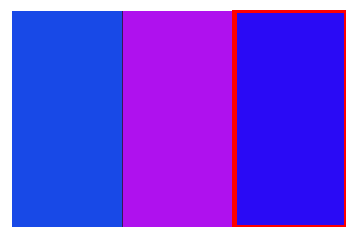

split
1) Game: 1124-1_1 Round: 1
The darker blue one


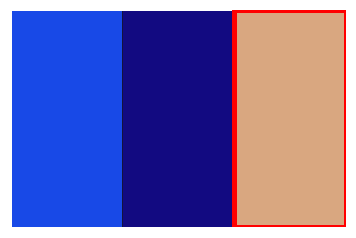

far
2) Game: 1124-1_2 Round: 1
The darker blue one


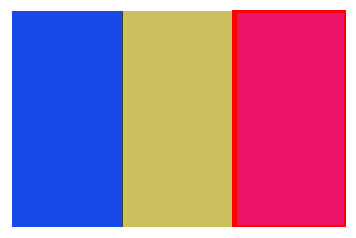

In [374]:
display_round(0)

far
3) Game: 1124-1_0 Round: 2
purple


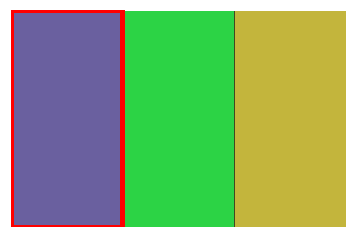

close
4) Game: 1124-1_1 Round: 2
purple


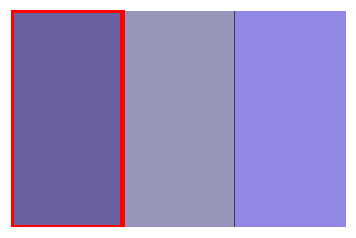

split
5) Game: 1124-1_2 Round: 2
purple


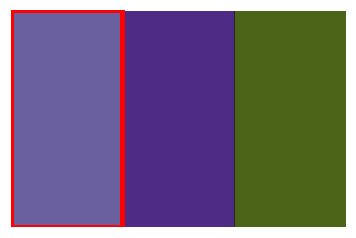

In [375]:
display_round(1)

In [389]:
cp_preds_str_subword[:3]

array(['split', 'far', 'close'], dtype='<U5')

In [390]:
cp_truth_str[:3]

array(['close', 'far', 'close'], dtype='<U5')

In [376]:
incorrect_inds = np.where(cp_preds_str_subword != cp_truth_str)

In [377]:
incorrect_inds = incorrect_inds[0]

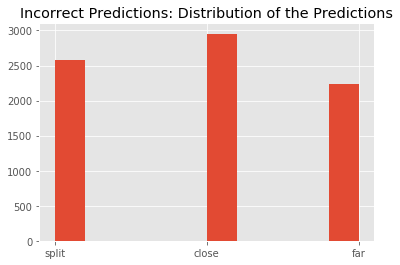

In [378]:
plt.hist(cp_preds_str_subword[incorrect_inds])
plt.title("Incorrect Predictions: Distribution of the Predictions")
plt.show()

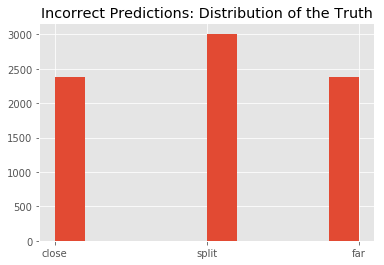

In [379]:
plt.hist(cp_truth_str[incorrect_inds])
plt.title("Incorrect Predictions: Distribution of the Truth")
plt.show()

So it looks like the biggest performance hit comes from predicting that colors in the split condition are actually in the close condition. I suppose this kind of makes sense though.

In [387]:
incorrect_inds[:10]

array([ 0,  3,  4,  6,  7,  8, 12, 16, 18, 19])

In [388]:
cp_preds_str_subword[incorrect_inds][:10]

array(['split', 'close', 'split', 'close', 'far', 'close', 'close',
       'split', 'far', 'far'], dtype='<U5')

split
9) Game: 1124-1_0 Round: 4
lime


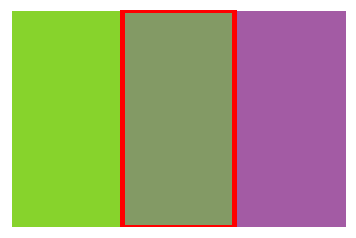

close
10) Game: 1124-1_1 Round: 4
lime


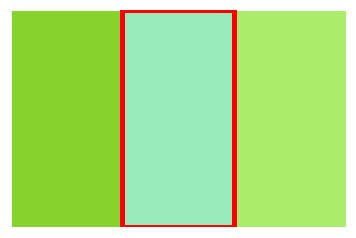

far
11) Game: 1124-1_2 Round: 4
lime


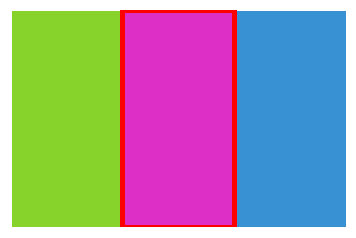

In [380]:
display_round(3)

far
12) Game: 1124-1_0 Round: 5
Mint green.


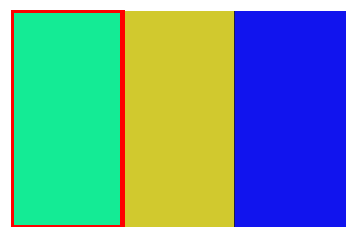

close
13) Game: 1124-1_1 Round: 5
Mint green.


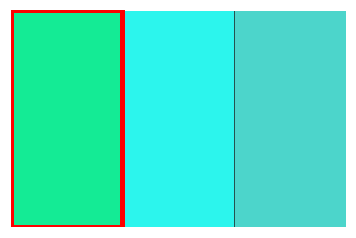

split
14) Game: 1124-1_2 Round: 5
Mint green.


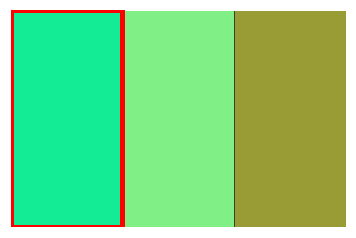

In [381]:
display_round(4)

split
18) Game: 1124-1_0 Round: 7
Mud brown


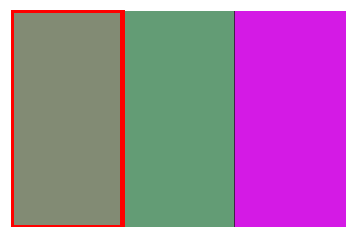

close
19) Game: 1124-1_1 Round: 7
Mud brown


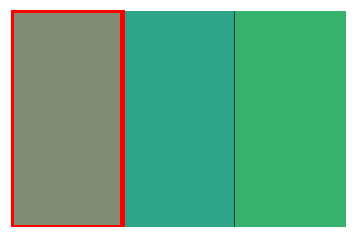

far
20) Game: 1124-1_2 Round: 7
Mud brown


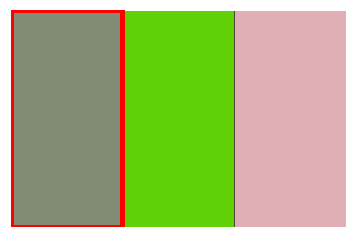

In [382]:
display_round(6)

In [383]:
cp_likelihood_subword = np.exp(((cp_likelihood.reshape(-1, 3).T) - logsumexp(cp_likelihood.reshape(-1, 3), axis=1)).T)

In [384]:
cp_likelihood_subword[0] # I don't understand why there's so much mass on the split condition when the caption is actually very bad for the split condition


array([0.26738313, 0.7301651 , 0.00245202], dtype=float32)

In [394]:
np.exp(cp_likelihood.reshape(-1, 3))

array([[3.5869187e-05, 9.7950942e-05, 3.2893635e-07],
       [5.7950264e-01, 2.1735817e-01, 2.8227651e-01],
       [3.5814737e-18, 2.1702433e-19, 1.1386709e-19],
       ...,
       [7.7216814e-13, 3.1269843e-13, 8.5731969e-13],
       [3.4942782e-01, 1.2481411e-01, 3.3723032e-01],
       [7.5079211e-06, 1.9168481e-06, 2.5803201e-05]], dtype=float32)

In [403]:
np.exp(output_to_likelihood(cp_outputs_subword[:1], y_assess_subword_cp[:1], target_idx=2))

array([2.512603e-07], dtype=float32)

In [404]:
np.exp(output_to_likelihood(cp_outputs_subword[:1], y_assess_subword_cp[:1], target_idx=0))

array([3.5869187e-05], dtype=float32)

In [405]:
np.exp(output_to_likelihood(cp_outputs_subword[:1], y_assess_subword_cp[:1], target_idx=1))

array([8.389205e-05], dtype=float32)

In [408]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_endings[:1], y_assess_endings_cp[:1], target_idx=t)))

0 [1.200255e-06]
1 [3.976873e-06]
2 [7.0392328e-09]


In [409]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_endings[1:2], y_assess_endings_cp[1:2], target_idx=t)))

0 [7.289446e-07]
1 [5.1525277e-09]
2 [8.961722e-08]


In [422]:
X_train_subword_cp_subword[:3]

NameError: name 'X_train_subword' is not defined

In [423]:
X_assess_subword_cp[:3]

[[array([0, 1, 2, 3, 4, 5]),
  array([[ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
          -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
           0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
          -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
           0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
          -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
          -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
           0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
           0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
          -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
           0.6280306 , -0.81116533,  0.6033464 , -0.34218323],
         [ 1.        , -0.97922283,  0.91775465, -0.97624546,  0.91202444,
          -0.8099048 ,  0.90611047, -0.8014967 ,  0.66357714,  0.22495106,
        

In [419]:
feature_handler_subword_cp.color_featurizer.to_color_features(train_cp_data[0].colors)

array([[ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
        -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
         0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
        -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
         0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
        -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
        -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
         0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
         0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
        -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
         0.6280306 , -0.81116533,  0.6033464 , -0.34218323],
       [ 1.        , -0.97922283,  0.91775465, -0.97624546,  0.91202444,
        -0.8099048 ,  0.90611047, -0.8014967 ,  0.66357714,  0.22495106,
        -0.02268733, -0.18051915, -0.00849321, -0.19446324,  0.

In [392]:
cp_all_conds_str.reshape(-1, 3)[incorrect_inds[0]]

array(['close', 'split', 'far'], dtype='<U5')

In [385]:
cp_likelihood_subword[incorrect_inds[1]]

array([0.42631775, 0.5342513 , 0.03943093], dtype=float32)

In [386]:
cp_all_conds_str.reshape(-1, 3)[incorrect_inds[1]]

array(['split', 'close', 'far'], dtype='<U5')

In [300]:
cp_preds_str_subword[incorrect_inds[1]]

'close'

In [301]:
cp_truth_str[incorrect_inds[1]]

'split'

In [302]:
cp_likelihood_subword[1]

array([0.53343534, 0.08819008, 0.37837458], dtype=float32)

In [303]:
cp_all_conds_str.reshape(-1, 3)[1]

array(['far', 'close', 'split'], dtype='<U5')

In [305]:
cp_likelihood_subword[16]

array([0.0189748 , 0.81390345, 0.16712154], dtype=float32)

In [304]:
cp_all_conds_str.reshape(-1, 3)[16]

array(['far', 'close', 'split'], dtype='<U5')

far
48) Game: 1124-1_0 Round: 17
Yellowish brownish orangish yellow ~ lol


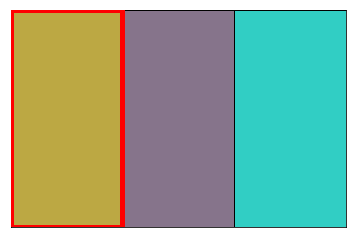

close
49) Game: 1124-1_1 Round: 17
Yellowish brownish orangish yellow ~ lol


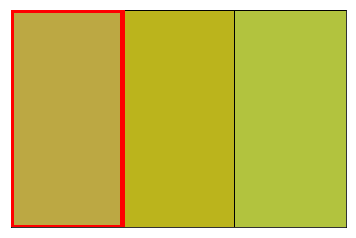

split
50) Game: 1124-1_2 Round: 17
Yellowish brownish orangish yellow ~ lol


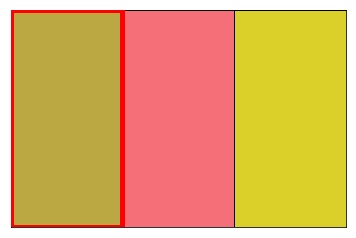

In [306]:
display_round(16)

In [319]:
pd.DataFrame(
    list(
        zip(train_cp_data.data.contents[3*incorrect_inds], 
            cp_preds_str_subword[incorrect_inds], 
            cp_truth_str[incorrect_inds])
    ),
    columns=["caption", "prediction", "truth"]
)

,caption,prediction,truth
0,The darker blue one,split,close
1,lime,close,split
2,Mint green.,close,far
3,Mud brown,close,far
4,Mud brown,far,split
5,Camo green,far,split
6,Darkish red,close,split
7,The more vibrantly red one... not the more pur...,close,split
8,blue,split,far
9,Yellowish brownish orangish yellow ~ lol,close,far


close
57) Game: 1124-1_0 Round: 20
Brown


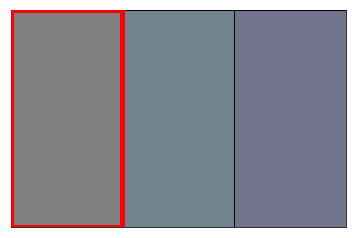

split
58) Game: 1124-1_1 Round: 20
Brown


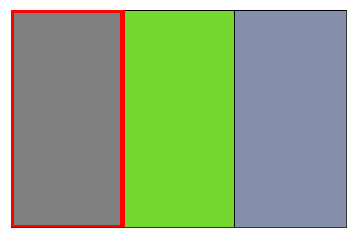

far
59) Game: 1124-1_2 Round: 20
Brown


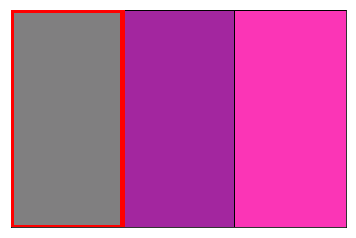

In [320]:
display_round(incorrect_inds[12])

In [336]:
from sklearn.metrics import confusion_matrix

In [344]:
x = confusion_matrix(y_true=cp_truth_str, y_pred=cp_preds_str_subword, labels=["close", "split", "far"])

In [347]:
print("close", "split", "far")
print(tabulate.tabulate(x))

close split far
----  ----  ----
3226  1008   925
1756  2181  1304
1343  1402  2520
----  ----  ----


In [338]:
cp_preds_str_subword

array(['split', 'far', 'close', ..., 'split', 'split', 'far'], dtype='<U5')

In [321]:
# measuring distance between distractors in the split condition:
train_data_split = train_data.data[train_data.data.condition == "split"]


In [330]:
train_data.data.head().T

,0,1,2,3,4
gameid,1124-1,1124-1,1124-1,1124-1,1124-1
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,2,3,4,5
condition,close,far,close,split,far
clickStatus,distr2,target,distr2,distr1,target
clickColH,248,249,291,85,156
clickColS,92,25,59,21,84
clickColL,50,50,50,50,50
clickLocS,3,1,3,2,1
clickLocL,1,2,3,1,3


In [324]:
np.train_data_split.D1D2Diff

3        57
6        46
7        38
8        53
12       31
13       69
17       84
18       61
21       35
22       27
23       30
28       38
29       75
31       62
35       39
36       23
49       90
57       66
62       26
63       54
64       58
68       37
69       62
74       22
76       63
78       39
79       22
81       59
82       37
90       44
         ..
15571    44
15575    33
15578    30
15583    35
15584    23
15585    48
15590    30
15594    58
15595    25
15597    39
15606    75
15610    87
15613    25
15614    66
15615    50
15616    77
15619    60
15624    33
15626    67
15628    34
15630    30
15631    60
15634    54
15635    36
15642    71
15645    30
15648    57
15651    42
15659    35
15662    70
Name: D1D2Diff, Length: 5241, dtype: int64

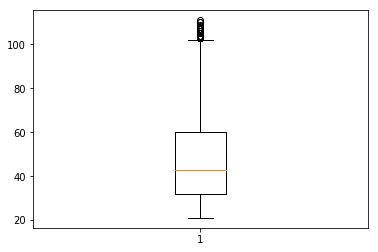

In [327]:
plt.boxplot(train_data_split.D1D2Diff)
plt.show()

In [328]:
min(train_data_split.D1D2Diff)

21

In [329]:
max(train_data_split.D1D2Diff)

111

In [367]:
train_cp_data.data.head().T

,0,1,2,3,4
gameid,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,1,1,2,2
condition,close,split,far,far,close
clickStatus,distr2,distr2,distr2,target,target
clickColH,248,27,337,249,249
clickColS,92,54,84,25,25
clickColL,50,68,50,50,50
clickLocS,3,3,3,1,1
clickLocL,1,1,1,2,2
